# __Кластеризація...__ mnist

алгоритм `K-means` для кластеризації

In [29]:
import os
from pathlib import Path
import random
from typing import Optional

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline


In [30]:
def set_seed(seed_value: int) -> None:
    """Set a random state for repeatability of results."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    # tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

set_seed(1)

### __`OBTAIN` & `SCRUB`__ + __`EXPLORE`__ (DATASET)

In [31]:
def read_from_csvfile(file: Path, header: Optional[str]='infer') -> pd.DataFrame:
    """Read content from csv-file and return dataframe from content."""
    df = pd.read_csv(file, header=header)
    
    return df

Читаємо всі датасети з файлів `csv` у папці `data2`

In [32]:
dfs = [read_from_csvfile(item, None) for item in Path('data2').iterdir() if item.is_file() and item.suffix.lower() in ('.csv',)]

Виділяємо різні набори

In [33]:
data_2d, mnist = dfs[0], dfs[1]

In [34]:
mnist.shape, data_2d.shape

((500, 785), (200, 3))

In [35]:
mnist.columns = ['y'] + [f'x{el}' for el in range(1, mnist.shape[1])]

In [36]:
mnist.head(3)

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x775,x776,x777,x778,x779,x780,x781,x782,x783,x784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Перевіримо чи є дублікати для першрго стовпця

In [37]:
not mnist['y'].is_unique, mnist['y'].min(), mnist['y'].max()

(True, 0, 9)

Перша колонка - кластери (позначення), то визначимо скільки значень у кожному:

In [38]:
clusters = {}
[clusters.update({el:1}) if (clusters.get(el) is None) else clusters.update({el:clusters.get(el)+1}) for el in mnist['y']]
clusters

{7: 49, 2: 55, 1: 67, 0: 42, 4: 55, 9: 54, 5: 50, 6: 43, 3: 45, 8: 40}

##### SCRUB & EXPLORE

In [39]:
def draw_2D_scatter(as_x: list, as_y: list, mark: Optional[str], title: str, xlabel: str, ylabel: str, figsize: tuple|None=None) -> None:
    size = figsize or (15, 5)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x)) / len(as_x)) or 1)
    minor_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x)) / len(as_x))/10 or 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y)) / len(as_y)) or 1)
    minor_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y)) / len(as_y))/10 or 0.1)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    plt.xticks(rotation=85)
    
    plt.scatter(as_x, as_y) if mark is None else plt.scatter(as_x, as_y, c=mark, cmap='viridis') 

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # ax.grid(which='both')
    plt.show()

In [40]:
mnist.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x775,x776,x777,x778,x779,x780,x781,x782,x783,x784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
Y = mnist['y']
df = mnist.drop('y', axis=1)

In [42]:
df.head(2)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x775,x776,x777,x778,x779,x780,x781,x782,x783,x784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Зменшимо розмірність за допомогою `Principal Component Analysis` та глянемо чи необхідна нормалізація
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [43]:
x_pca = PCA(n_components=2).fit_transform(df)

In [44]:
min(x_pca[:, 0]), max(x_pca[:, 0]), min(x_pca[:, 1]), max(x_pca[:, 1])

(-1168.3517405522068,
 2079.474771209342,
 -1123.167391704613,
 1208.5861419972503)

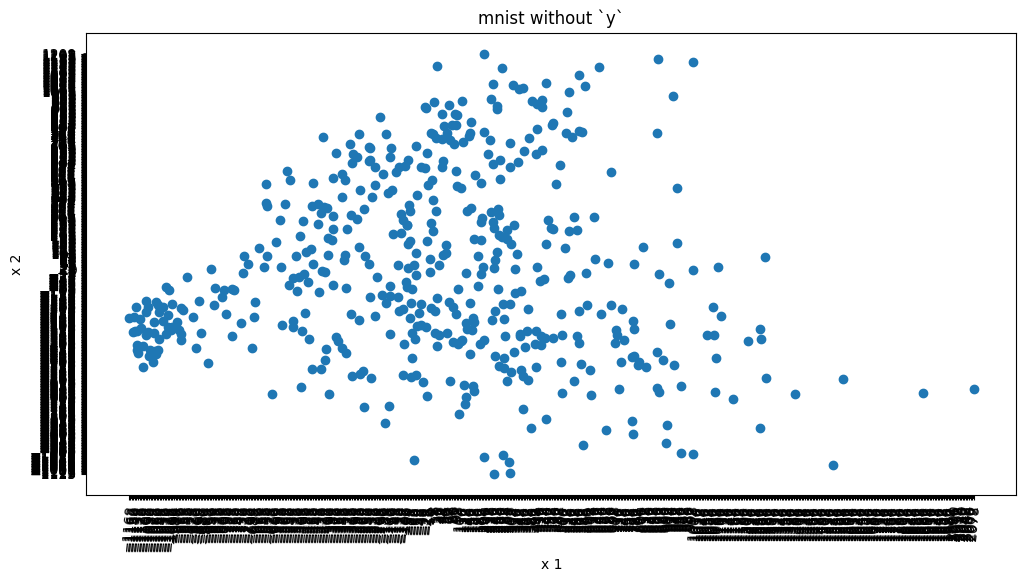

In [45]:
size = (12, 6)
draw_2D_scatter(as_x=x_pca[:, 0], as_y=x_pca[:, 1], mark=None, title=f'mnist without `y`', xlabel='x 1', ylabel=f'x 2', figsize=size)

Як бачимо необхідна нормалізація. Нормалізуємо значення фіч:

In [46]:
x_norm = StandardScaler().fit_transform(df)

In [47]:
x_pca = PCA(n_components=2).fit_transform(x_norm)

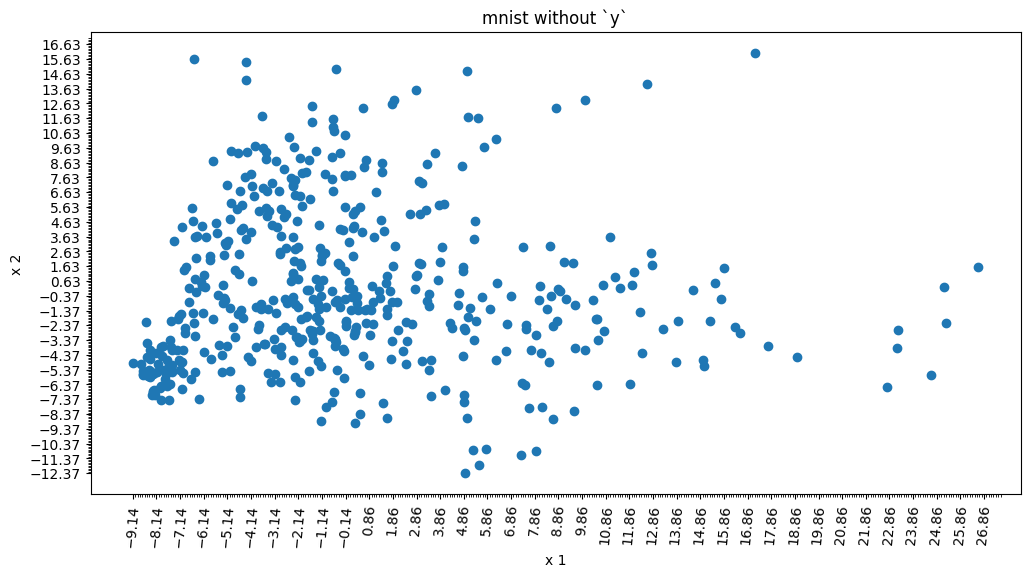

In [48]:
size = (12, 6)
draw_2D_scatter(as_x=x_pca[:, 0], as_y=x_pca[:, 1], mark=None, title=f'mnist without `y`', xlabel='x 1', ylabel=f'x 2', figsize=size)

### __`MODEL`__ & __`Training`__

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [49]:
def draw_2D(as_x: list, as_y: list, title: str, xlabel: str, ylabel: str, figsize: tuple|None=None) -> None:
    size = figsize or (15, 5)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x))/len(as_x)) or 1)
    minor_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x))/len(as_x)/10) or 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y))/len(as_y)) or 1)
    minor_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y))/len(as_y)/10) or 0.1)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)

    plt.plot(
             as_x, 
             as_y, 
            #  label=f'2D', 
             color=random.choice('rgbcmyk'), 
             linestyle=random.choice(['-', '--', '-.', ':', None]),
             marker=random.choice('o+xdvs*.^')
             )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    ax.grid(which='both')
    plt.show()

- https://stackoverflow.com/questions/51762514/find-the-elbow-point-on-an-optimization-curve-with-python
- https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python/13849249#13849249
- https://github.com/arvkevi/kneed

Розрахуємо для розбиття на кластери від 1 до 11

In [50]:
X = x_pca
x = [n_clus for n_clus in range(1, 12)]
kmeans2 = [KMeans(n_clusters=n_clus, random_state=0, n_init='auto').fit(X) for n_clus in x]
y = [km.inertia_ for km in kmeans2]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


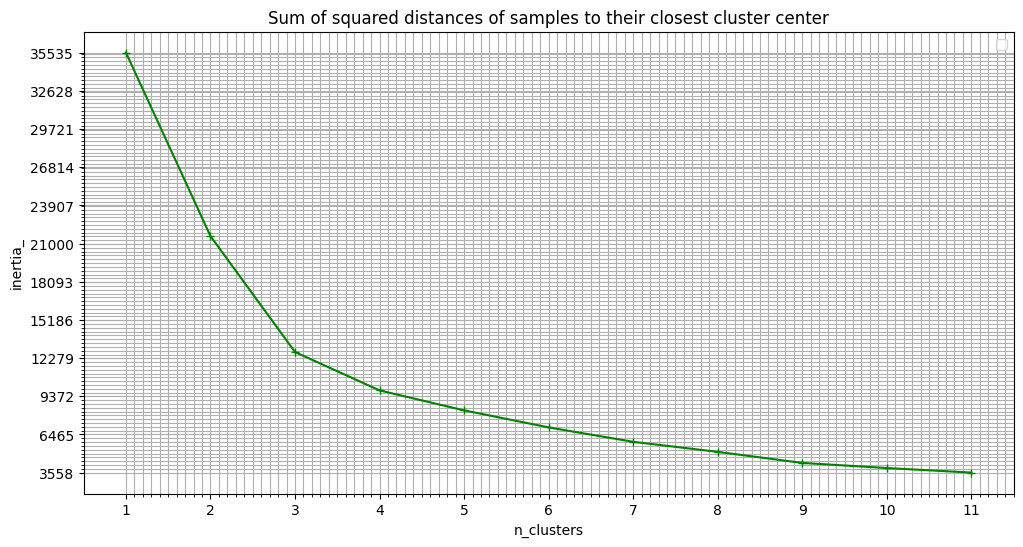

In [51]:
title = 'Sum of squared distances of samples to their closest cluster center'
draw_2D(as_x=x, as_y=y, title=title, xlabel='n_clusters', ylabel=f'inertia_', figsize=(12, 6))

Візуально начебто 3 кластери оптимально, але ...

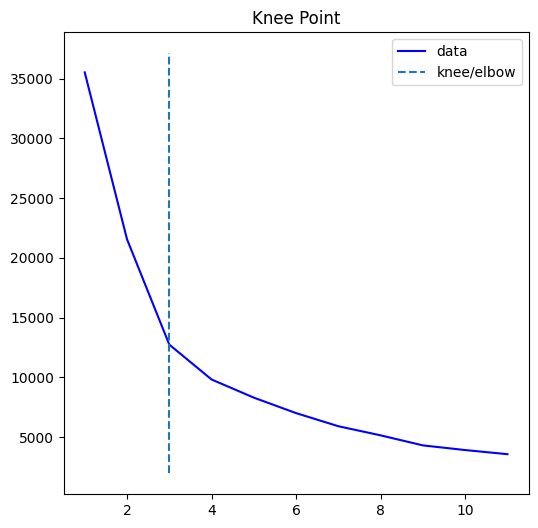

In [52]:
kneedle2 = KneeLocator(x, y, S=1.0, curve='convex', direction='decreasing')
kneedle2.plot_knee()

Теж 3 класи

In [53]:
kmeans2[2]

KMeans(n_clusters=3, n_init='auto', random_state=0)

### __`INTERPRET`__ / __`Error Analysis`__

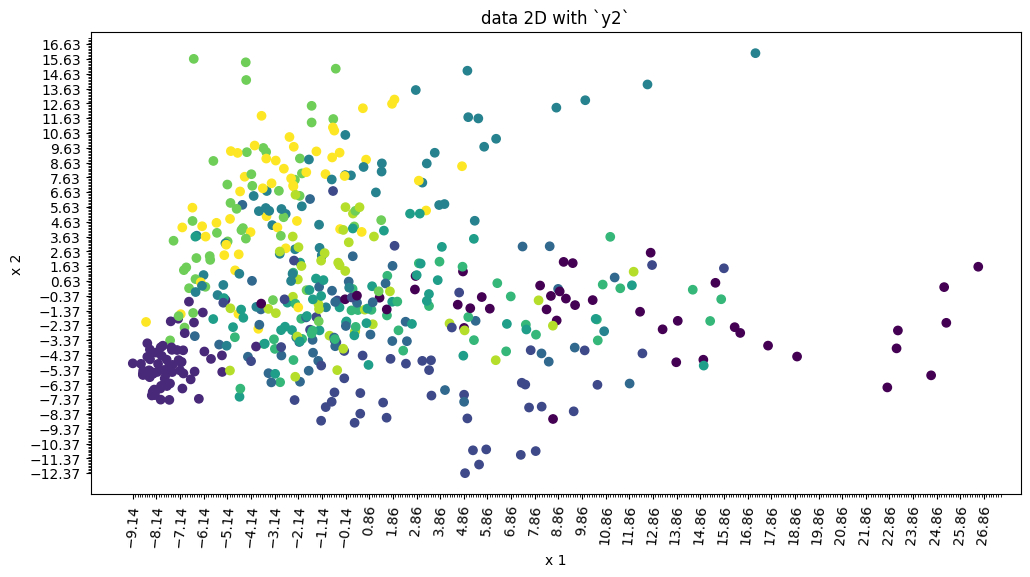

In [54]:
draw_2D_scatter(as_x=x_pca[:, 0], as_y=x_pca[:, 1], mark=Y.values, title=f'data 2D with `y2`', xlabel='x 1', ylabel=f'x 2', figsize=size)

In [55]:
kmeans2[2].labels_

array([1, 0, 2, 0, 1, 2, 1, 1, 0, 1, 0, 0, 1, 0, 2, 0, 1, 1, 0, 1, 2, 2,
       1, 2, 1, 0, 1, 1, 0, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2,
       0, 1, 2, 0, 1, 0, 0, 2, 2, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 1,
       2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 2, 2, 0,
       0, 1, 2, 2, 0, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 0, 0, 2, 1, 1, 2, 2,
       2, 2, 1, 1, 2, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 0, 0, 2, 2, 2, 0, 1, 0, 2, 2, 2,
       1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 0, 1, 1, 2, 1, 2, 1, 0, 2, 2, 2, 2,
       1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1,
       0, 1, 2, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 1,
       2, 2, 0, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2,
       2, 1, 2, 2, 1, 0, 1, 2, 0, 1, 0, 0, 0, 2, 2,

In [56]:
kmeans2[2].cluster_centers_

array([[ 9.83744502, -2.6780397 ],
       [-1.12974478,  6.45396681],
       [-3.53859562, -3.07429565]])

In [57]:
centroids = pd.DataFrame(kmeans2[2].cluster_centers_)
centroids.columns = ['x1', 'x2']
centroids

,x1,x2
0,9.837445,-2.678040
1,-1.129745,6.453967
2,-3.538596,-3.074296


Додамо результат кластеризації - позначення `y3`

In [58]:
data_mnist = pd.DataFrame(x_pca)
data_mnist.columns = ['x1', 'x2']
y3 = pd.DataFrame({'y3':kmeans2[2].labels_})
data_mnist_c = pd.concat([data_mnist, y3], axis=1)
data_mnist_c.head()

,x1,x2,y3
0,-4.477953,4.202834,1
1,4.914638,-12.369918,0
2,-6.994595,-5.628599,2
3,8.546182,-0.384812,0
4,1.144530,6.615418,1


Додамо центроїди

In [59]:
c3 = pd.DataFrame({'y3':[centroids.shape[0] + i for i in range(centroids.shape[0])], })
c3 = pd.concat([c3, centroids], axis=1)
data_mnist_c = pd.concat([data_mnist_c, c3], axis=0, ignore_index=True)
data_mnist_c.tail(6)

,x1,x2,y3
497,-6.210691,0.301779,2
498,0.342835,-0.364405,2
499,-4.819824,-3.177233,2
500,9.837445,-2.678040,3
501,-1.129745,6.453967,4
502,-3.538596,-3.074296,5


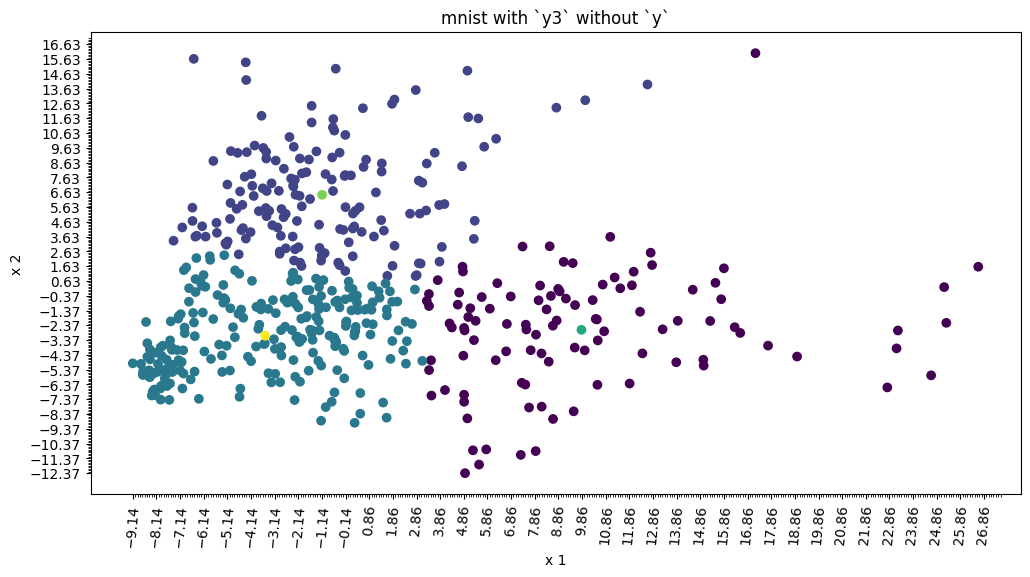

In [60]:
draw_2D_scatter(
                as_x=data_mnist_c['x1'], 
                as_y=data_mnist_c['x2'], 
                mark=data_mnist_c['y3'], 
                title=f'mnist with `y3` without `y`', 
                xlabel='x 1', 
                ylabel=f'x 2', 
                figsize=size
                )

### __`Implement`__

In [61]:
kmeans2[2].predict([[2.86, -10], [-4, 2.13], [8, 8], [2.9, -0.4], [26, -10], [15, 17], [-10, 17], [-10, -10]])

array([2, 1, 1, 2, 0, 1, 1, 2], dtype=int32)